In [435]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 

In [436]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [437]:
# ImageNet statistics for normalization (Standard for VGG/ResNet/Inception)
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

In [438]:
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    return transform(image).unsqueeze(0).float() #adding batch dimension

def deprocess_image(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = image.numpy().transpose((1, 2, 0))
    
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return Image.fromarray((image * 255).astype(np.uint8))
    

In [439]:
class LayerHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.output = None
    
    def hook_fn(self, model, input, output):
        self.output =  output

    def close(self):
        self.hook.remove()

In [440]:
class Clip:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(1, 3, 1, 1).to(device)
        self.std = torch.tensor(std).view(1, 3, 1, 1).to(device)
        
        # Calculate the lower bound (Pixel value 0)
        self.lower = (0.0 - self.mean) / self.std
        # Calculate the upper bound (Pixel value 1)
        self.upper = (1.0 - self.mean) / self.std

    def __call__(self, tensor):
        # Clip each channel to its specific valid range
        return torch.clamp(tensor, self.lower, self.upper)

clipper = Clip(mean, std)

In [441]:
def deep_dream_step(image_tensor, model, layer_hook, iterations, lr):
    image_tensor.requires_grad_(True)

    for i in range(iterations):
        model.zero_grad()
        model(image_tensor)
        
        layer_activations = [hook.output for hook in layer_hook]
        
        total_loss = sum(activation.mean() for activation in layer_activations)
        total_loss.backward()

        with torch.no_grad():
            grad = image_tensor.grad / (torch.std(image_tensor.grad)+1e-8)
            image_tensor += lr * grad
            image_tensor.data = clipper(image_tensor.data)
            
            image_tensor.grad.zero_()

    return image_tensor


In [442]:
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [443]:
def upscale_and_inject_details(current_image, original_image, current_shape, next_shape):
    """Upscales the image and reinjects details lost during downscaling."""
    # Upscale the current dreamed image
    upscaled_image = torch.nn.functional.interpolate(current_image, size=next_shape, mode='bicubic')
    
    # Calculate lost details from the original image:
    # Get original image at the target (next) size
    original_next = torch.nn.functional.interpolate(original_image, size=next_shape, mode='bicubic')
    
    # Simulate the information loss: Downscale original to previous size, then upscale back
    original_prev_down = torch.nn.functional.interpolate(original_image, size=current_shape, mode='bicubic')
    original_prev_up = torch.nn.functional.interpolate(original_prev_down, size=next_shape, mode='bicubic')
    
    # Extract the high-frequency details (difference between true image and blurred image)
    lost_details = original_next - original_prev_up
    
    return upscaled_image + lost_details
    

In [444]:
def deepdream(img_path, model, layer_idx=(22,), octaves=5, octave_scale=1.4, iterations=20, lr=0.05):
    model.eval()

    hooks = []
    for layer in layer_idx:
        target_layer = model[layer]
        hooks.append(LayerHook(target_layer))

    original_img = Image.open(img_path).convert("RGB")
    original_tensor = preprocess_image(original_img).to(device)
    
    # List of shapes for each octave
    octave_shapes = []
    base_shape = original_tensor.shape[-2:] # Height, Width
    
    for n in range(octaves):
        new_h = int(base_shape[0] * (1.0 / (octave_scale ** n)))
        new_w = int(base_shape[1] * (1.0 / (octave_scale ** n)))
        octave_shapes.append((new_h, new_w))
    
    # We iterate from the smallest image to the largest
    octave_shapes = list(reversed(octave_shapes))
    
    # Initialize image with the smallest size
    image_tensor = torch.nn.functional.interpolate(original_tensor, size=octave_shapes[0], mode='bicubic')
    
    image_tensor = image_tensor.detach().clone()

    for i, shape in enumerate(octave_shapes):
        print(f"Processing Octave {i+1}/{octaves} shape: {shape}")
        
        # Dream at the current size
        image_tensor = deep_dream_step(image_tensor, model, hooks, iterations, lr)
        
        # If this isn't the last octave, prepare for the next size (Upscale + Detail Injection)
        if i < len(octave_shapes) - 1:
            next_shape = octave_shapes[i+1]
            
            image_tensor = upscale_and_inject_details(image_tensor, original_tensor, shape, next_shape)

            # reset gradients
            image_tensor = image_tensor.detach().clone()

    for hook in hooks:
        hook.close()

    return deprocess_image(image_tensor)

Processing Octave 1/5 shape: (163, 245)
Processing Octave 2/5 shape: (212, 318)
Processing Octave 3/5 shape: (276, 414)
Processing Octave 4/5 shape: (359, 538)
Processing Octave 5/5 shape: (467, 700)


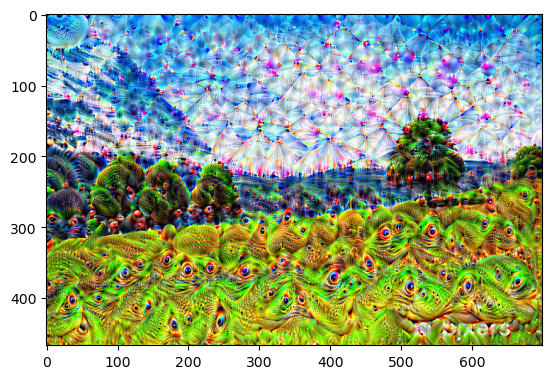

In [445]:
result = deepdream("landscape.jpg", model, layer_idx=(7, 29), octaves=5, octave_scale=1.3, iterations=100, lr=0.01)
plt.imshow(result)
plt.show()